### Importing Lib's

In [2]:
import torch
from torch import nn
from pathlib import Path
from torch import nn
import torchvision
from torchvision import transforms,datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import random
from PIL import Image
import matplotlib.pyplot as plt

### Creating Test and Train Data

In [3]:
dir_path = Path("data")
dir_path
train_dir = dir_path / "train"
test_dir = dir_path / "test"

random_images = list(dir_path.glob("*/*/*.jpg"))

### Opening any random image

(np.float64(-0.5), np.float64(47.5), np.float64(47.5), np.float64(-0.5))

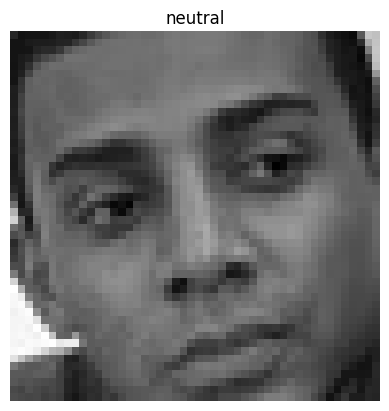

In [4]:
img = random.choice(random_images)
t = img.parent.stem
img = Image.open(img)
plt.imshow(img, cmap="gray")
plt.title(t)
plt.axis("off")

### Creating tranformer 

In [5]:
data_transform = transforms.Compose([
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor(),
])

### Checking the transform on a single image


(np.float64(-0.5), np.float64(47.5), np.float64(47.5), np.float64(-0.5))

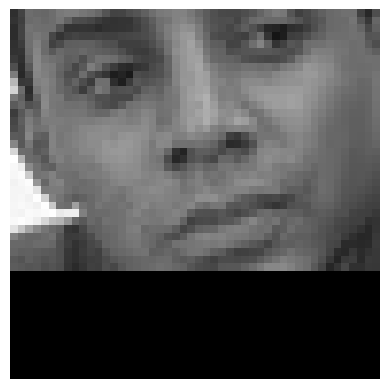

In [6]:
tran_img = data_transform(img)

plt.imshow(tran_img.permute(1,2,0),cmap="gray")
plt.axis("off")

### Creating datasets and dataloader

In [7]:
train_dataset = datasets.ImageFolder(root=train_dir,transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_dir,transform=data_transform)

train_dataloader = DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=8)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=32,shuffle=False,num_workers=8)

# train_dataloader,test_dataloader
# len(train_dataset),len(test_dataset)
train_dataset[0][0].shape,train_dataset.classes[train_dataset[0][1]]
classes = train_dataset.classes
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

### Creating model architect (TinyVGG)


In [8]:
class TinyVGG(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*9*9,out_features=output_shape)
        )
    def forward(self,x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


model = TinyVGG(input_shape=3,hidden_units=10,output_shape=len(classes))

### creating training and testing loop

In [9]:
from tqdm.auto import tqdm
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        outputs = model(X)
        logits = outputs.logits  # ✅ Extract logits properly
        
        # Compute loss
        loss = loss_fn(logits, y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item()
        acc = (logits.argmax(dim=1) == y).float().mean().item()  # ✅ Compute accuracy properly
        train_acc += acc

    return train_loss / len(dataloader), train_acc / len(dataloader)


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item()/len(y_pred)
            test_acc += acc
    return test_loss/len(dataloader),test_acc/len(dataloader)

def train(model,train_dataloader,test_dataloader,loss_fn,optimizer,epochs,device):
    result = {
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss,train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss,test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        result["train_loss"].append(train_loss)
        result["train_acc"].append(train_acc)
        result["test_loss"].append(test_loss)
        result["test_acc"].append(test_acc)
        print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")
    return result

# result = train(model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,epochs=5,device=device)


# result

## Plotting Loss Curve

In [10]:
def plot_loss_curves(results):
    """
    Plots training curves of a results dictionary.
    
    Args:
        results (dict): Dictionary containing lists of values, specifically:
            - train_loss
            - train_acc
            - test_loss
            - test_acc
    """
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Train Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

# plot_loss_curves(result)

### Fine Tunning the Google ViT-B-16 Model

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text(0.5, 1.0, 'neutral')

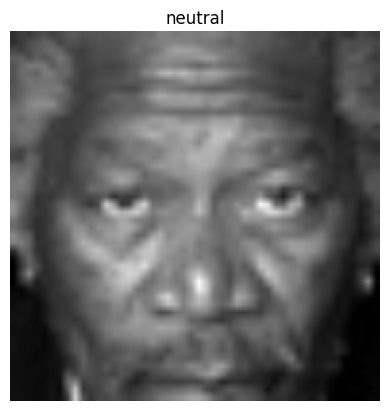

In [45]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_1 = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(classes))
model_1.to(device)

optimizer_1 = torch.optim.Adam(params=model_1.parameters(), lr=1e-5)

# Freezing all the parameters of the model
for param in model_1.parameters():
    param.requires_grad = False

# Unfreezing the classifier parameters of the model
for param in model_1.classifier.parameters():
    param.requires_grad = True

data_transform_1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor(),
])

train_dataset_1 = datasets.ImageFolder(root=train_dir, transform=data_transform_1)
test_dataset_1 = datasets.ImageFolder(root=test_dir, transform=data_transform_1)
train_dataloader_1 = DataLoader(dataset=train_dataset_1, batch_size=7, shuffle=True, num_workers=8, pin_memory=True)
test_dataloader_1 = DataLoader(dataset=test_dataset_1, batch_size=7, shuffle=False, num_workers=8, pin_memory=True)


train_dataset_1[0][0].shape,train_dataset_1.classes[train_dataset_1[0][1]]

import random
i = random.randint(0, len(train_dataset_1)-1)
img = train_dataset_1[i][0]

plt.imshow(img.permute(1,2,0),cmap="gray")
plt.axis("off")
plt.title(train_dataset_1.classes[train_dataset_1[i][1]])

In [12]:

train_loss = []
train_acc = []
test_loss = []
test_acc = []
EPOCHS = 5

for epoch in tqdm(range(EPOCHS)):
    print(f"{epoch + 1}/{EPOCHS}.........")
    model_1.train()

    train_loss_epoch = 0
    train_acc_epoch = 0
    test_loss_epoch = 0
    test_acc_epoch = 0

    for X, y in train_dataloader_1:
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        outputs = model_1(X).logits
        loss = loss_fn(outputs, y)
        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()

        train_loss_epoch += loss.item()
        acc = (outputs.argmax(1) == y).sum().item() / len(y)
        train_acc_epoch += acc
        train_loss.append(loss.item())
        train_acc.append(acc)

    train_loss_epoch /= len(train_dataloader_1)
    train_acc_epoch /= len(train_dataloader_1)
    print(f"Train loss: {train_loss_epoch:.5f} | Train acc: {train_acc_epoch:.2f}")

    model_1.eval()
    with torch.inference_mode():
        for X, y in test_dataloader_1:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model_1(X).logits
            loss = loss_fn(y_pred, y)

            test_loss_epoch += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item() / len(y)
            test_acc_epoch += acc
            test_loss.append(loss.item())
            test_acc.append(acc)

    test_loss_epoch /= len(test_dataloader_1)
    test_acc_epoch /= len(test_dataloader_1)
    print(f"Test loss: {test_loss_epoch:.5f} | Test acc: {test_acc_epoch:.2f}")

plot_loss_curves({"train_loss": train_loss, "train_acc": train_acc, "test_loss": test_loss, "test_acc": test_acc})
model_1.save_pretrained("model")

  0%|          | 0/5 [00:00<?, ?it/s]

1/5.........


  0%|          | 0/5 [00:05<?, ?it/s]


KeyboardInterrupt: 